# Kr analysis (MC)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Wed Mar 29 19:32:29 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_MC_FirstApproach/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/2948/"

pattern = "$IC_DATA/run_2948.gdcsnext.*.next1el_2948.root.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))

# files: 108


### Define event class

In [65]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []
        self.S1t   = []


        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []
        self.S2t   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.ok    = False

### Define dataset class

In [62]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [66]:
@timefunc
def fill_evts(s1s, s2s, sis, evts_out, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = len(s1)
        evt.nS2 = len(s2)

        s1time = 0
        for peak, (t, e) in s1.items():
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]
            evt.S1t.append(s1time)

        s2time = 0
        for peak, (t, e) in s2.items():
            evt.S2w.append(width(t, to_mus=True))
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]
            evt.S2t.append(s2time)

            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        fill_evts(pmapf.df_to_pmaps_dict(s1s),
                  pmapf.df_to_pmaps_dict(s2s),
                  pmapf.df_to_s2si_dict (sis),
                  evts_out, ifile)
    return Dataset(evts_out)


# Read data

In [67]:
full = build_dataset(ifiles)

/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.026.next1el_2948.root.h5 262
Time spent in fill_evts: 0.2583940029144287 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.063.next1el_2948.root.h5 262
Time spent in fill_evts: 0.20267343521118164 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.089.next1el_2948.root.h5 262
Time spent in fill_evts: 0.2396531105041504 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.010.next1el_2948.root.h5 259
Time spent in fill_evts: 0.21281027793884277 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.000.next1el_2948.root.h5 262
Time spent in fill_evts: 0.1828153133392334 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.034.next1el_2948.root.h5 259
Time spent in fill_evts: 0.21163725852966309 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.106.next1el_2948.root.h5 264
Time spent in fill_evts: 0.19101381301879883 s
/home/brais/Documents/Next/Na/data/2948/run_2948.gdcsnext.084.nex

## General plots about S1 and S2 (no selections applied)

In [68]:
data = full

#### Number of S1 and S2 signals

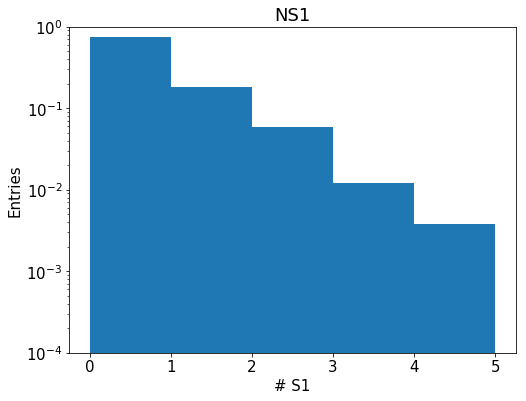

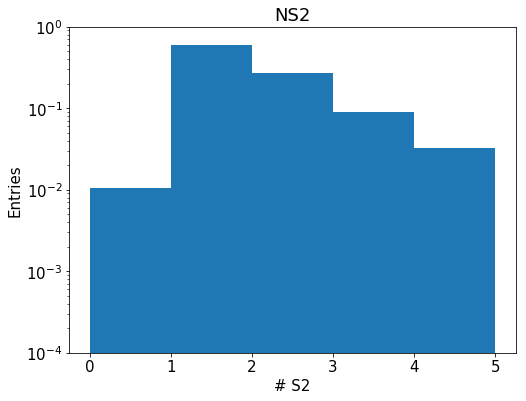

In [69]:
pdf(data.nS1, 5, range=(0, 5))
labels("# S1", "Entries")
save("NS1")

################################
pdf(data.nS2, 5, range=(0, 5))
labels("# S2", "Entries")
save("NS2")


## From now on the study is focused on those events with exactly one S1 and one S2

In [70]:
oneS1oneS2 = full[full.ok]
data = oneS1oneS2
print("Full set   :", full.evts.size, "events")
print("Reduced set:", data.evts.size, "events")
print("Ratio      :", data.evts.size/full.evts.size)

Time spent in _create_attrs: 0.061602115631103516 s
Full set   : 28164 events
Reduced set: 2879 events
Ratio      : 0.10222269563982389


<b>
The ratio of "reliable" to total events is ~69.19%
</b>

## Distribution of events in Z

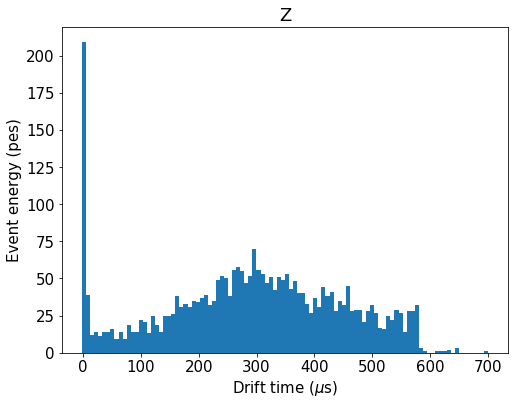

In [71]:
hist(data.Z, 100)
labels("Drift time ($\mu$s)", "Event energy (pes)")
save("Z")    

<b>
1. The number of events under these conditions is not uniformly distributed in Z. Near the anode about ~70% of the events lack S1.
2. Integrating the lack of events in the whole chamber, we get a Kr detection efficiency of 69.2%.
</b>

## Width of S1 signals

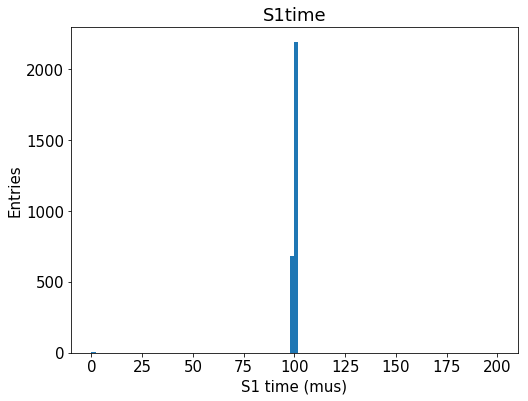

In [78]:
s1t = flat(data.S1t)/1e3

################################
hist(s1t, 100, range=(0, 2e2))
labels("S1 time (mus)", "Entries")
save("S1time")

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


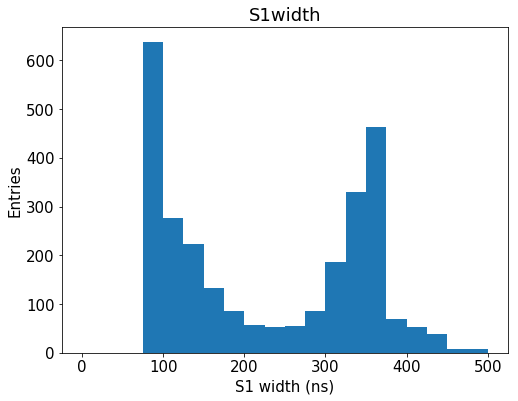

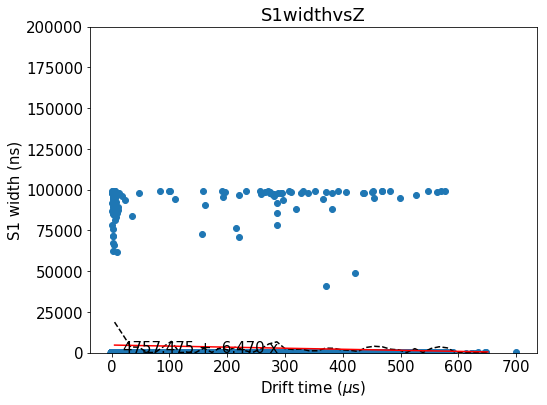

In [79]:
s1w = flat(data.S1w)

################################
hist(s1w, 20, range=(0, 500))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
scatter(data.Z, s1w)
x, y, _ = fitf.profileX(data.Z, s1w, 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 1.))
plt.plot(x, f.fn(x), fitOpt)
plt.text(20, 20, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "S1 width (ns)")
plt.ylim(0, 2e5)
save("S1widthvsZ")



<b>
1. The typical width of an S1 goes up to 400 ns, however, it looks like we are cutting the distribution at 150 ns as it drops abruptly at 150 ns. This is caused by a parameter in the production, which can be relaxed
for future productions.
2. The distribution as a function of Z shows a slight dependence (16% difference between extremes). Although it seems irrelevant, it may be larger if shorter S1s are permitted.

</b>

# Height of S1 signals

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


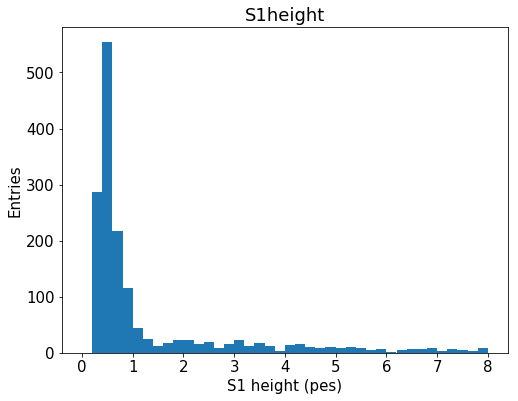

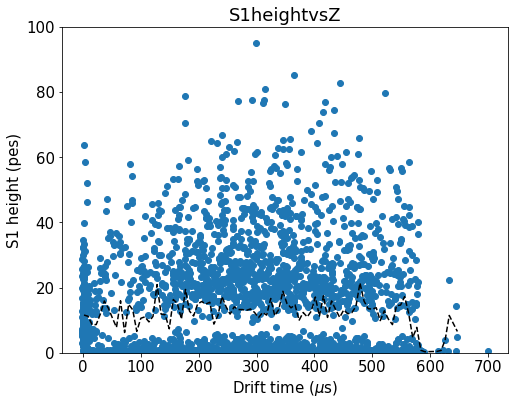

In [29]:
s1h = flat(data.S1h)

################################
hist(s1h, 40, range=(0, 8))
labels("S1 height (pes)", "Entries")
save("S1height")

################################
scatter(data.Z, s1h)
x, y, _ = fitf.profileX(data.Z, s1h, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 0.8, 0.01))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 6, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("Drift time ($\mu$s)", "S1 height (pes)")
plt.ylim(0, 100)
save("S1heightvsZ")

<b>
1. The average height of an S1 is around 2 pes, but it grows roughly linearly with z. Near the anode, the height is ~1 pes on average, which is *NOT* high enough to not be confused with noise (the S1 width cut can play a role here).
</b>

## S1 energy

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


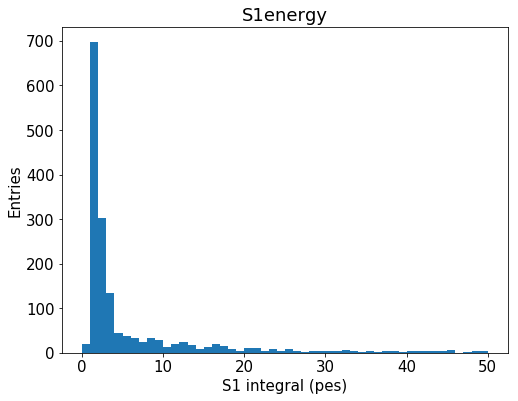

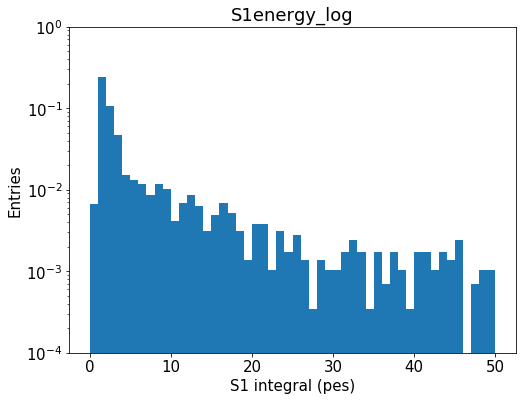

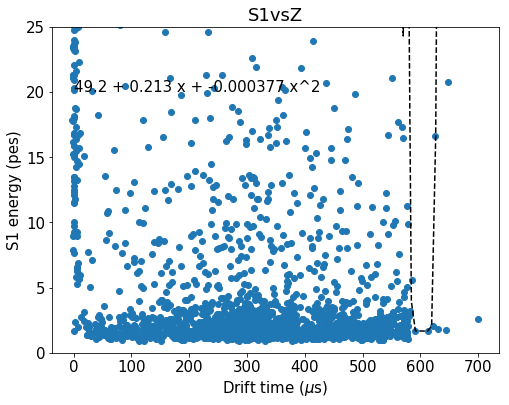

In [15]:
s1i = flat(data.S1i)

################################
hist(s1i, 50, range=(0, 50))
labels("S1 integral (pes)", "Entries")
save("S1energy")

################################
pdf(s1i, 50, range=(0, 50))
labels("S1 integral (pes)", "Entries")
save("S1energy_log")

################################
scatter(data.Z, s1i)
x, y, _ = fitf.profileX(data.Z, s1i, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 1e-2, 1e-4))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 20, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("Drift time ($\mu$s)", "S1 energy (pes)")
plt.ylim(0, 25)
save("S1vsZ")

## S1 peak-to-area ratio

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:119: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


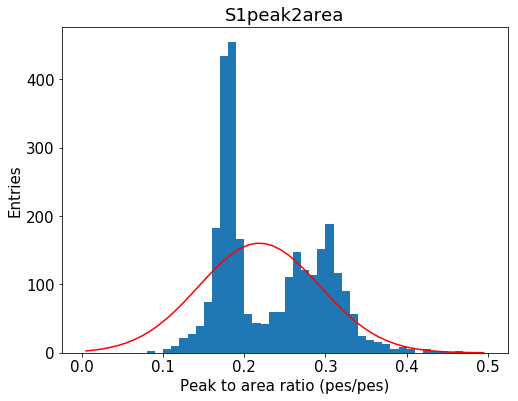

In [16]:
################################
y, x, _ = hist(s1h/s1i, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area")

<b>
1. The peak to area ratio is roughtly gaussianly distributed. On average, the ratio is ~26%.
</b>

## Width of S2 signals

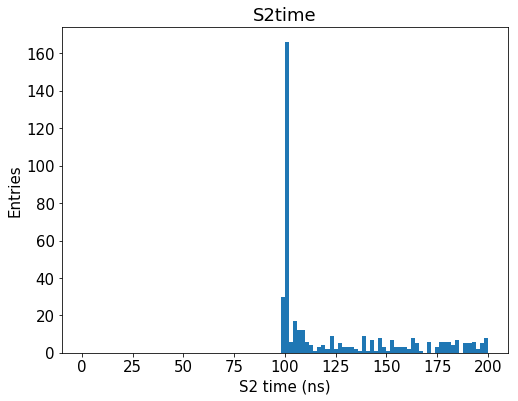

In [74]:
s2t = flat(data.S2t)/1e3

################################
hist(s2t, 100, range=(0, 2e2))
labels("S2 time (ns)", "Entries")
save("S2time")

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


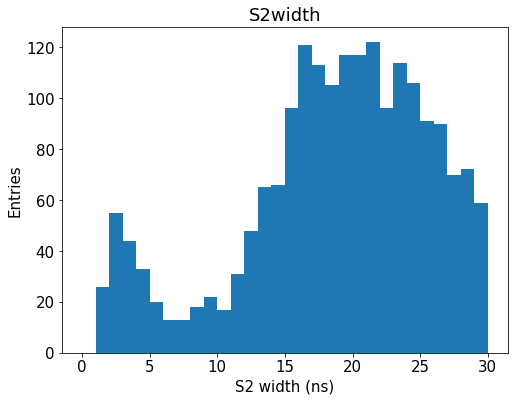

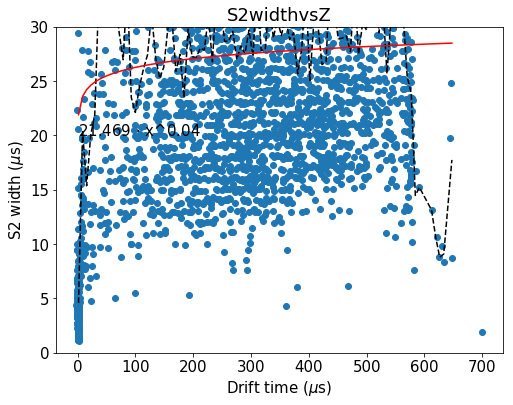

In [17]:
s2w = flat(data.S2w)

################################
hist(s2w, 30, range=(0, 30))
labels("S2 width (ns)", "Entries")
save("S2width")

################################
scatter(data.Z, s2w)
x, y, _ = fitf.profileX(data.Z, s2w, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 20, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
plt.ylim(0, 30)
save("S2widthvsZ")

# Height of S2 signals

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:50: RuntimeWarning: invalid value e

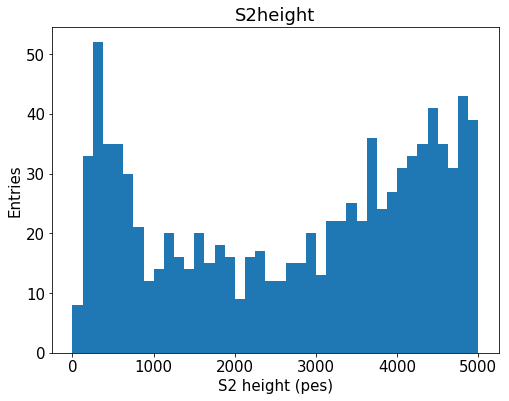

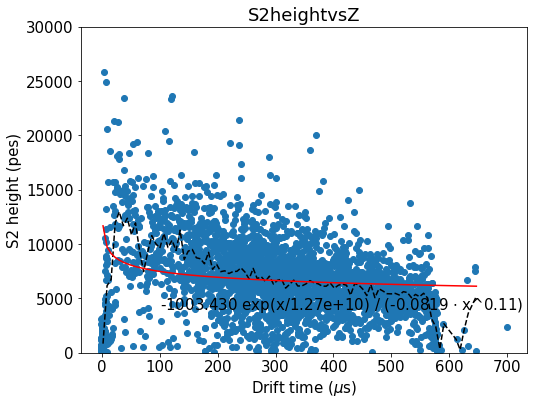

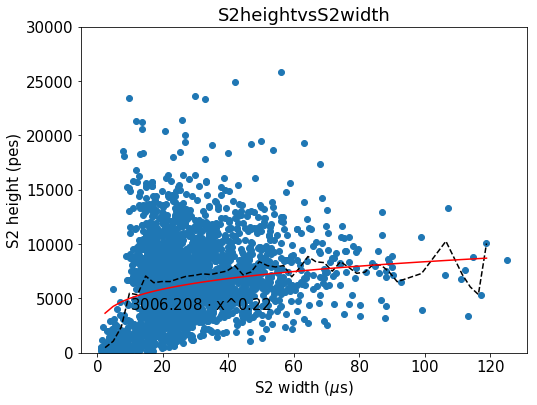

In [24]:
s2h = flat(data.S2h)

################################
hist(s2h, 40, range=(0, 5e3))
labels("S2 height (pes)", "Entries")
save("S2height")

################################
scatter(data.Z, s2h)
x, y, _ = fitf.profileX(data.Z, s2h, 100)
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fun, x, y, (1., -2e4, 0.1, -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(1e2, 4e3, "{:.3f} exp(x/{:.3g}) / "
                   "({:.3g} $\cdot$ x^{:.2f})".format(*f.values))
labels("Drift time ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 3e4)
save("S2heightvsZ")

################################
scatter(s2w, s2h)
x, y, _ = fitf.profileX(s2w, s2h, 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (1., -1.0))
plt.plot(x, f.fn(x), fitOpt)
plt.text(10, 4e3, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("S2 width ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 3e4)
save("S2heightvsS2width")


## S2 energy

In [ ]:
s2i = flat(data.S2i)

################################
hist(s2i, 50, range=(0, 8e3))
labels("S2 integral (pes)", "Entries")
save("S2energy")

################################
pdf(s2i, 50, range=(0, 8e3))
labels("S2 integral (pes)", "Entries")
save("S2energy_log")

################################
scatter(data.Z, s2i)
x, y, _ = fitf.profileX(data.Z, s2i, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.expo, x, y, (7e3, -1))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 2200, "{:.1f} $\cdot$ exp(-x/{:.4g})".format(*f.values))
labels("Drift time ($\mu$s)", "Event energy (pes)")
plt.ylim(2e3, 8e3)
save("EvsZ")


<b>
1. The integrated Kr S2 signal peaks around 6500 pes, but it depends strongly on the geometrical position of the event (more on that later). When unfolding the distribution in Z, we find that there is a (non-negligible) dependence. The difference is a 2% which for this scale, represents ~110 pes. Since the MC was generated without any type of attachment, this dependence must be introduced somewhere in the IC code (Diomira?, Irene (when performing the deconvolution)?).
</b>

## S2 peak-to-area ratio

In [ ]:
################################
hist(s2h/s2i, 50, range=(0, 0.6))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2area")

<b>
1. The peak to area ratio seems to be composed of different types of peaks (~0.2, ~0.32, ~0.42, ~0.5). Not yet understood, but surely related to the structure found in the height of S2 signals.
</b>

## S2 vs S1

In [ ]:
################################
scatter(s1i, s2i)
x, y, _ = fitf.profileX(s1i, s2i, 100, (0, 20))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (6e3, -1.))
plt.plot(x, f.fn(x), fitOpt)
plt.text(12, 3200, "{:.3f} + {:.3f} x".format(*f.values))
labels("S1 energy (pes)", "S2 energy (pes)")
plt.xlim(0, 20)
plt.ylim(2e3, 8e3)
save("S2vsS1")


<b>
1. S2 energy is also (anti)correlated with S1 charge. I don’t know where does this come from as there is no recombination in the MC. It may be caused purely by the S2 vs Z dependence.
</b>

## Number of SiPMs touched

In [ ]:
nsipm = flat(data.Nsipm)

################################
hist(nsipm, 10, range=(0, 10))
labels("Number of charged SiPMs", "Entries")
save("Nsipm")

################################
scatter(data.Z, nsipm)
x, y, _ = fitf.profileX(data.Z, nsipm, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (2, -1e-5, -1e-2, -1e-3))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3.5, "{:.3g} + {:.3g} x + {:.3g} x^2 + {:.3g} x^3".format(*f.values))
labels("Drift time ($\mu$s)", "Number of SiPMs touched")
save("NsipmvsZ")

################################
selection = ~np.isnan(data.R)
R = data.R[selection]
scatter(R, nsipm[selection])
x, y, _ = fitf.profileX(R, nsipm[selection], 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.expo, x, y, (1., -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3.2, "{:.3f} exp(x/{:.2f})".format(*f.values))
labels("r (mm)", "Number of SiPMs touched")
save("NsipmvsR")


<b>
1. The number of SiPMs with signal over threshold is not very high. In fact, we are lucky to reach 4. Is this a problem of the low gain? Or is it a harsh cut for zero-suppression?
2. Unfolding the distribution in z tells us that the farther from the anode, the lesser SiPMs are touched, on average. I expected the oposite, as transverse diffusion should make it easier to reach more sensors (more on that later). A possible explanation for this effect is that the spread caused by diffusion makes the signal over noise ratio in the SiPMs quite small making it difficult for them to pass the ZS cut.
3. The number of SiPMs does not depend significantly on the transverse position of the event as shown.
4. The last plot is made with Nsipm>0 (as R would not make sense).
</b>

## To study geometrical dependendes, we will select those events with Nsipm > 0

In [ ]:
atleast1sipm = oneS1oneS2[flat(oneS1oneS2.Nsipm) > 0]
data         = atleast1sipm

## Event distribution in the X, Y plane

In [ ]:
X, Y, R, Phi = flat(data.X), flat(data.Y), flat(data.R), flat(data.Phi)

################################
hist(X, 100, range=(-220, 220))
labels("x (mm)", "Entries")
save("X")

################################
hist(Y, 100, range=(-220, 220))
labels("y (mm)", "Entries")
save("Y")

################################
hist(R, 100, range=(0, 220))
labels("r (mm)", "Entries")
save("R")

################################
hist(Phi, 100, range=(-pi, pi))
labels("$\phi$ (rad)", "Entries")
save("Phi")

################################
hist2d(X, Y, 100, range=((-220, 220),
                         (-220, 220)))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(R, Phi, 100, range=((  0, 220),
                           (-pi, pi )))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")


<b>
1. The distribution of events (computed using the barycenter) is, as expected, quite homogeneous if we ignore the strip pattern. It seems that the differences in bin contents are small, with the only exception of the hole in (5, -155).
2. Because there is a dead SiPM at that position and because of the low number of SiPMs touched, the events that should be reconstructed at (5, -155) are biased towards the closest neighbors.
3. The strip pattern is clearly caused by the the small number of charged SiPMs (particularly when Nsipm = 1). This makes the outcome kind of discrete and biased.
</b>

## S2 charge

In [ ]:
################################
s2q = flat(data.Q)
hist(s2q, 100, range=(0, 600))
labels("Tracking plane charge (pes)", "Entries")
save("S2Q")

################################
pdf(s2q, 100, range=(0, 600))
labels("Tracking plane charge (pes)", "Entries")
save("S2Q_log")

<b>
1. The total charge (integral of the tracking plane) is weirdly distributed, not even close to a gaussian form. We need to look at its dependences.
</b>

In [ ]:
################################
scatter(data.Z, s2q)
x, y, _ = fitf.profileX(data.Z, s2q, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (400, -1, 0.1, 0.01))
plt.plot(x, f.fn(x), fitOpt)
plt.text(50, 550, "{:.3g} + {:.3g} x + {:.3g} x^2 + {:.3g} x^3".format(*f.values))
labels("Drift time ($\mu$s)", "Traking Plane integral (pes)")
save("QvsZ")

################################
ave = f.fn(data.Z[data.Z<200])
y, x, _ = hist((s2q[data.Z<200] - ave)/ave**0.5, 100, range=(-10, 10))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 5))
plt.plot(x, f.fn(x), "r")
labels("Traking Plane integral - average value (pes)", "Entries")
save("QvsZ_shifted")

In [ ]:
nsipm = flat(data.Nsipm)
################################
scatter(nsipm, s2q)
x, y, _ = fitf.profileX(nsipm, s2q, 100, xrange=(0, 5))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (100, 0.7))
plt.plot(x, f.fn(x), fitOpt)
plt.text(2.5, 50, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("Number of SiPMs touched", "S2 charge (pes)")
save("QvsNsipm")

In [ ]:
################################
plt.figure()
x, y, q, qe = fitf.profileXY(X, Y, s2q, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 charge (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

################################
plt.figure()
x, y, q, qe = fitf.profileXY(R, Phi, s2q, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 charge (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

################################
scatter(R, s2q)
x, y, _ = fitf.profileX(R, s2q, 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (200, -0.001))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 600, "{:.3g} + {:.3g} x".format(*f.values))
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

################################
scatter(Phi, s2q)
x, y, _ = fitf.profileX(Phi, s2q, 100)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 charge (pes)")
save("QvsPhi")

<b>
After taking a look to the dependencies of this magnitude we see that:
    - Charge collection is homogeneous in the TP.
    - It depends on the number of SiPMs touched, but this magnitude depends on Z.
    - There is a strong dependence on Z. While events occurring near the anode have ~400 pes, it is very likely to miss those happening near the cathode. On the other hand, if we take Q - averageQ for Z < 200 mus, the distribution seems gaussianly distributed, as expected. Therefore, we can conclude that charge variation in Z is the dominant effect in the TP.
</b>

In [ ]:
s2e = flat(data.S2i)

################################
plt.figure()
x, y, q, qe = fitf.profileXY(X, Y, s2e, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("Event energy (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

################################
plt.figure()
x, y, q, qe = fitf.profileXY(R, Phi, s2e, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 energy (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

################################
scatter(R, s2e)
x, y, _ = fitf.profileX(R, s2e, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (6e3, -1e-2, 1e-2, -1e-3, -1e-4, 1e-6, 1e-7))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3e3, "{:.3g} + {:.3g} x + {:.3g} x^2 + \n"
                 "{:.3g} x^3 + {:.3g} x^4 + {:.3g} x^5 +\n"
                 "{:.3g} x^6".format(*f.values))
labels("r (mm)", "Event energy (pes)")
save("EvsR")

################################
scatter(Phi, s2e)
x, y, _ = fitf.profileX(Phi, s2e, 100)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "Event energy (pes)")
save("EvsPhi")

<b>
1. Finally, the dependence of the energy with the position is obvious. The behaviour in R and $\phi$ are the ones expected from the parametrization. The Kr energy map seems quite good, even with the bias introduced by the small number of SiPMs touched (although the bins are 4mm wide). There are still some holes for which we only need more statistics, but there is a big one at the position of the dead SiPM. Unless we can increase the number of SiPMs touched and/or the light they receive, I don’t think we can do a better energy map.
</b>

In [ ]:
################################
scatter(s2e, s2q)
plt.xlim(3500)
x, y, _ = fitf.profileX(s2e, s2q, 100, (4700, 7200))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (200, 1e-2, 1e-4))
plt.plot(x, f.fn(x), fitOpt)
plt.text(3600, 600, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("S2 energy (pes)", "S2 charge (pes)")
save("QvsE")

<b>
1. The meaning of the charge vs energy plot is not clear. The only dependences are Q(Z) and E(R) (E(z) is negligible compared with the other one), so the quadratic correlation does not seem obvious to me.
</b>

In [ ]:
################################
qsipm = flat(data.Qsipm)
hist(qsipm, 100, range=(0, 600))
labels("SiPM charge (pes)", "Entries")
save("SipmQ")

################################
pdf(qsipm, 100, range=(0, 600))
labels("SiPM charge (pes)", "Entries")
save("SipmQ_log")

<b>
1. The charge per SiPM shows that the majority of them have less than 100 pes, but, in the best-case scenario, they can reach up to 400 pes. However, since this charge is time-integrated, the lower bound of the distribution is shifted towards the ~5 pes/$\mu$s region, very close to the ZS cut.
</b>

In [ ]:
################################
order, charge, norm_charge = [], [], []
for evt in data.Qsipm:
    for peak in evt:
        maxq = np.sum(peak)
        for i, q in enumerate(sorted(peak, reverse=True)):
            order.append(i)
            charge.append(q)
            norm_charge.append(q/maxq)

order, charge, norm_charge = map(np.array, [order, charge, norm_charge])
scatter(order, charge)
x, y, _ = fitf.profileX(order, charge, 100, (0, 4))
plt.plot(x, y, profOpt)
labels("Ordering", "SiPM charge (pes)")
save("SipmQordered")

###########################
scatter(order, norm_charge)
x, y, _ = fitf.profileX(order, norm_charge, 100, (0, 4))
plt.plot(x, y, profOpt)
labels("Ordering", "SiPM normalized charge (pes/pes)")
save("SipmQnormordered")

## Spread of the events

In [ ]:
################################
hist(flat(data.Xrms), 100, range=(0, 10))
labels("rms x (mm)", "Entries")
save("rmsX_full")

################################
hist(flat(data.Yrms), 100, range=(0, 10))
labels("rms y (mm)", "Entries")
save("rmsY_full")

<b>
1. The spread of the event can be measured by the standard deviation of X and Y. These plots show how the distributions of these variables are affected by those events with Nsipm=1. Therefore, to perform this study we must get rid of those events with rms=0.
</b>

In [ ]:
rmsnotzero = data[(data.Xrms > 1e-3) & (data.Yrms > 1e-3)]
data = rmsnotzero

In [ ]:
xrms, yrms = data.Xrms, data.Yrms

################################
hist(xrms, 100, range=(0, 10))
labels("rms x (mm)", "Entries")
save("rmsX")

################################
hist(yrms, 100, range=(0, 10))
labels("rms y (mm)", "Entries")
save("rmsY")

################################
scatter(data.Z, xrms)
x, y, _ = fitf.profileX(data.Z, xrms, 100, yrange=(0,30))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(100, 5, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "rms x (mm)")
save("rmsXvsZ")

################################
scatter(data.Z, yrms)
x, y, _ = fitf.profileX(data.Z, yrms, 100, yrange=(0,30))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(100, 5, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "rms y (mm)")
save("rmsYvsZ")

<b>
1. The same distributions after the second selection are more clear. These are unfolded in Z and it seems that the spread of the event increases slightly with Z, but this plot is biased because of the Nsipm > 1 selection. However, even when selecting events with the same number of charged SiPMs, the same distribution shows up again, so the effect is real. It would be interesting to reproduce this with a higher number of SiPMs touched.
</b>